In [60]:
import pandas_datareader as web
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.stats import norm
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.optimize import minimize
from scipy.stats import norm
import numpy_financial as npf
import requests

In [4]:

def generate_df(file_name):
    df = pd.read_csv(f"./data/coincodex2/{file_name}")
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date',inplace=True)
    df = df.iloc[::-1]
    df = df[df.index >= datetime(2020,12,1)]
    df.head()
    return df

In [5]:
eth_df = generate_df("ethereum_2020-12-1_2022-5-1.csv")
sol_df = generate_df("solana_2020-12-1_2022-5-1.csv")
avax_df = generate_df("avalanche_2020-12-1_2022-5-1.csv")
luna_df = generate_df("terra_2020-12-1_2022-5-1.csv")
near_df = generate_df("near-protocol_2020-12-1_2022-5-1.csv")
ftm_df = generate_df("fantom_2020-12-1_2022-5-1.csv")
near_df

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2020-12-01,1.074047,1.136187,1.006713,1.075536,6.359005e+07,2.129790e+08
2020-12-02,1.061392,1.200548,1.045444,1.176352,9.519486e+07,2.282041e+08
2020-12-03,1.178527,1.193433,1.137444,1.155287,3.854613e+07,2.285274e+08
2020-12-04,1.155418,1.221788,1.097605,1.106827,3.739559e+07,2.284427e+08
2020-12-05,1.103230,1.142237,1.023442,1.111261,5.681561e+07,2.111705e+08
...,...,...,...,...,...,...
2022-04-27,12.679900,13.236634,12.458217,12.821237,2.126101e+09,8.757228e+09
2022-04-28,12.865400,13.109000,12.279441,12.390900,1.587002e+09,8.640117e+09
2022-04-29,12.403400,12.523900,11.140600,11.238076,1.430643e+09,8.018380e+09


In [6]:
principal_usd = 100000000
coins = ['ETH','SOL','AVAX','LUNA','NEAR','FTM']
coin_allocations = [0.40,0.25,0.12,0.13,0.05,0.05]
sum(coin_allocations)
coin_principals = [i*principal_usd for i in coin_allocations]
coin_principals
coin_init_amounts = []

In [7]:
portfolio_df = pd.concat([eth_df['Close'],sol_df['Close'],avax_df['Close'],luna_df['Close'],near_df['Close'],ftm_df['Close']],axis=1)
portfolio_df.columns = coins
portfolio_df

,ETH,SOL,AVAX,LUNA,NEAR,FTM
Date,,,,,,
2020-12-01,589.814467,1.977516,3.576271,0.388320,1.075536,0.020539
2020-12-02,598.357253,2.112355,3.745825,0.406310,1.176352,0.022646
2020-12-03,616.904853,2.098405,3.819472,0.506414,1.155287,0.022888
2020-12-04,571.978333,1.856668,3.556966,0.451015,1.106827,0.021042
2020-12-05,595.548506,1.977440,3.630332,0.509040,1.111261,0.022497
...,...,...,...,...,...,...
2022-04-27,2893.559731,98.309653,69.829573,89.065569,12.821237,0.986282
2022-04-28,2938.545100,98.129000,67.262100,88.665600,12.390900,0.968966
2022-04-29,2817.726674,93.942711,63.307263,84.902554,11.238076,0.832615


In [8]:
# Round for ETH Tranches this gives number of required validator nodes
round((principal_usd*coin_allocations[0]) / float(portfolio_df['ETH'].iloc[0]),2) // 32

2119.0

In [9]:
ETH_ALLOC = coin_allocations[0]
ETH_NET_ALLOC_USD = (ETH_ALLOC * principal_usd)
ETH_INIT_AMNT = round(ETH_NET_ALLOC_USD / float(portfolio_df['ETH'].iloc[0]),2)
portfolio_df['ETH_AMNT'] = ETH_INIT_AMNT
portfolio_df['ETH_NET'] = round(ETH_INIT_AMNT * portfolio_df['ETH'],2)

SOL_ALLOC = coin_allocations[1]
SOL_NET_ALLOC = (SOL_ALLOC * principal_usd)
SOL_INIT_AMNT = round(SOL_NET_ALLOC / float(portfolio_df['SOL'].iloc[0]))
portfolio_df['SOL_AMNT'] = SOL_INIT_AMNT
portfolio_df['SOL_NET'] = round(SOL_INIT_AMNT * portfolio_df['SOL'],2)

AVAX_ALLOC = coin_allocations[2]
AVAX_NET_ALLOC = (AVAX_ALLOC * principal_usd)
AVAX_INIT_AMNT = round(AVAX_NET_ALLOC / float(portfolio_df['AVAX'].iloc[0]))
portfolio_df['AVAX_AMNT'] = AVAX_INIT_AMNT
portfolio_df['AVAX_NET'] = round(AVAX_INIT_AMNT * portfolio_df['AVAX'],2)

LUNA_ALLOC = coin_allocations[3]
LUNA_NET_ALLOC = (LUNA_ALLOC * principal_usd)
LUNA_INIT_AMNT = round(LUNA_NET_ALLOC / float(portfolio_df['LUNA'].iloc[0]))
portfolio_df['LUNA_AMNT'] = LUNA_INIT_AMNT
portfolio_df['LUNA_NET'] = round(LUNA_INIT_AMNT * portfolio_df['LUNA'],2)

NEAR_ALLOC = coin_allocations[4]
NEAR_NET_ALLOC = (NEAR_ALLOC * principal_usd)
NEAR_INIT_AMNT = round(NEAR_NET_ALLOC / float(portfolio_df['NEAR'].iloc[0]))
portfolio_df['NEAR_AMNT'] = NEAR_INIT_AMNT
portfolio_df['NEAR_NET'] = round(NEAR_INIT_AMNT * portfolio_df['NEAR'],2)

FTM_ALLOC = coin_allocations[5]
FTM_NET_ALLOC = (FTM_ALLOC * principal_usd)
FTM_INIT_AMNT = round(FTM_NET_ALLOC / float(portfolio_df['FTM'].iloc[0]))
portfolio_df['FTM_AMNT'] = FTM_INIT_AMNT
portfolio_df['FTM_NET'] = round(FTM_INIT_AMNT * portfolio_df['FTM'],2)

portfolio_df

,ETH,SOL,AVAX,LUNA,NEAR,FTM,ETH_AMNT,ETH_NET,SOL_AMNT,SOL_NET,AVAX_AMNT,AVAX_NET,LUNA_AMNT,LUNA_NET,NEAR_AMNT,NEAR_NET,FTM_AMNT,FTM_NET
Date,,,,,,,,,,,,,,,,,,
2020-12-01,589.814467,1.977516,3.576271,0.388320,1.075536,0.020539,67817.94,4.000000e+07,12642123,2.500000e+07,3355450,1.200000e+07,33477563,1.300000e+07,4648847,5000000.28,243437355,5.000000e+06
2020-12-02,598.357253,2.112355,3.745825,0.406310,1.176352,0.022646,67817.94,4.057936e+07,12642123,2.670465e+07,3355450,1.256893e+07,33477563,1.360227e+07,4648847,5468682.27,243437355,5.512987e+06
2020-12-03,616.904853,2.098405,3.819472,0.506414,1.155287,0.022888,67817.94,4.183722e+07,12642123,2.652829e+07,3355450,1.281605e+07,33477563,1.695351e+07,4648847,5370750.32,243437355,5.571880e+06
2020-12-04,571.978333,1.856668,3.556966,0.451015,1.106827,0.021042,67817.94,3.879039e+07,12642123,2.347223e+07,3355450,1.193522e+07,33477563,1.509888e+07,4648847,5145471.11,243437355,5.122469e+06
2020-12-05,595.548506,1.977440,3.630332,0.509040,1.111261,0.022497,67817.94,4.038887e+07,12642123,2.499904e+07,3355450,1.218140e+07,33477563,1.704143e+07,4648847,5166080.90,243437355,5.476639e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-27,2893.559731,98.309653,69.829573,89.065569,12.821237,0.986282,67817.94,1.962353e+08,12642123,1.242843e+09,3355450,2.343096e+08,33477563,2.981698e+09,4648847,59603968.74,243437355,2.400979e+08
2022-04-28,2938.545100,98.129000,67.262100,88.665600,12.390900,0.968966,67817.94,1.992861e+08,12642123,1.240559e+09,3355450,2.256946e+08,33477563,2.968308e+09,4648847,57603398.29,243437355,2.358825e+08
2022-04-29,2817.726674,93.942711,63.307263,84.902554,11.238076,0.832615,67817.94,1.910924e+08,12642123,1.187635e+09,3355450,2.124244e+08,33477563,2.842331e+09,4648847,52244096.65,243437355,2.026895e+08


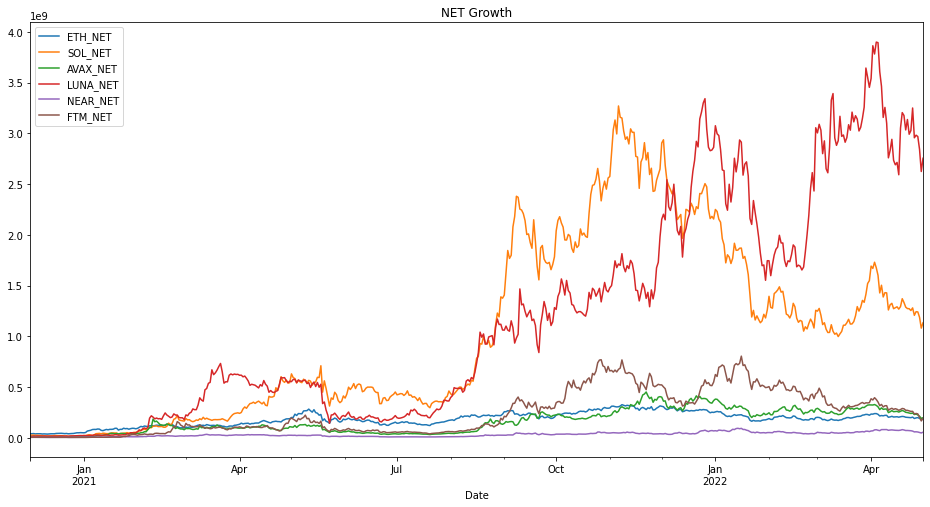

In [10]:
pl = portfolio_df.plot(y=['ETH_NET','SOL_NET','AVAX_NET','LUNA_NET','NEAR_NET','FTM_NET'],figsize=(16,8),title='NET Growth')

In [11]:
float(portfolio_df['LUNA_NET'].iloc[0])

13000000.09

In [12]:
float(portfolio_df['LUNA_NET'].iloc[-1])

2754235933.33

In [13]:
round((float(portfolio_df['LUNA_NET'].iloc[-1]) - float(portfolio_df['LUNA_NET'].iloc[0])) / float(portfolio_df['LUNA_NET'].iloc[0]) * 100)

21086

In [14]:
## Calculate fixed staking rates and assume daily compound
x = 0.00011719067956206253
p = 1000
z = 1000
z1 = z

# A = the future value of the investment/loan, including interest
# P = the principal investment amount (the initial deposit or loan amount)
# r = the annual interest rate (decimal)
# n = the number of times that interest is compounded per unit t
# t = the time the money is invested or borrowed for

# so if i convert the annualized interested to daily then 
# i becomes 1 for daily because it is compounded 1/day per unit t which is a day so 
# day/day = 1
# https://www.thecalculatorsite.com/articles/finance/compound-interest-formula.php
# https://calculate.onl/expected-return-portfolio-calculator/
# https://numpy.org/numpy-financial/latest/


for i in range(0,366):
    z = z * (1+x)
    #print(f"z:{z}")
    a = p * (1 + x) ** (i)
    r = p * (((1+x) ** (i)) - 1)
    print(f"day:{i} a:{a}, r:{r}")




day:0 a:1000.0, r:0.0
day:1 a:1000.1171906795621, r:0.11719067956206253
day:2 a:1000.2343950927794, r:0.23439509277944914
day:3 a:1000.3516132412618, r:0.3516132412617612
day:4 a:1000.4688451266186, r:0.4688451266186
day:5 a:1000.5860907504596, r:0.5860907504595669
day:6 a:1000.7033501143949, r:0.7033501143949294
day:7 a:1000.8206232200349, r:0.820623220034955
day:8 a:1000.9379100689897, r:0.9379100689896891
day:9 a:1001.0552106628703, r:1.0552106628702873
day:10 a:1001.172525003287, r:1.1725250032870171
day:11 a:1001.289853091851, r:1.2898530918510343
day:12 a:1001.4071949301733, r:1.4071949301732722
day:13 a:1001.5245505198656, r:1.524550519865553
day:14 a:1001.641919862539, r:1.6419198625390319
day:15 a:1001.7593029598055, r:1.759302959805531
day:16 a:1001.8766998132771, r:1.876699813277094
day:17 a:1001.9941104245655, r:1.9941104245655428
day:18 a:1002.1115347952833, r:2.111534795283365
day:19 a:1002.2289729270431, r:2.228972927043049
day:20 a:1002.3464248214573, r:2.34642482145730

In [31]:
eth_yield_df = pd.concat([eth_df['Close'],portfolio_df['ETH_AMNT'],portfolio_df['ETH_NET'],],axis=1)
eth_yield_df.columns = ['ETH_CLOSE_PRICE','ETH_AMNT','ETH_NET']
ETH_ANNUAL_YIELD = 8.00 #4.37
ETH_ANNUAL_YIELD_PERCENTAGE = ETH_ANNUAL_YIELD / 100
#i_daily = (1 + i_annual) ^ (1/365) – 1
ETH_DAILY_YIELD_PERCENTAGE = (1 + ETH_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_ETH_YIELD_AMNT = ETH_INIT_AMNT * ETH_DAILY_YIELD_PERCENTAGE
print(ETH_DAILY_YIELD_PERCENTAGE)
print(INITIAL_DAILY_ETH_YIELD_AMNT)
eth_yield_df['Daily_Rate'] = ETH_DAILY_YIELD_PERCENTAGE
eth_yield_df['Day_Count'] = 1
eth_yield_df['Day_Count_Cum'] = eth_yield_df['Day_Count'].cumsum()
eth_yield_df['ETH_AMNT_YIELD'] = eth_yield_df['ETH_AMNT'] * (1 + ETH_DAILY_YIELD_PERCENTAGE) ** (eth_yield_df['Day_Count_Cum'])
#eth_yield_df['ETH_AMNT'] + (eth_yield_df['ETH_AMNT'] * eth_yield_df['Daily_Rate']).cumsum()
#eth_yield_df['ETH_AMNT_YIELD_2'] = eth_yield_df['ETH_AMNT'] * (1 + ETH_DAILY_YIELD_PERCENTAGE) ** (eth_yield_df['Day_Count_Cum'])
#p * (1 + x) ** (i)
#df["Principal"] = np.ppmt(Interest_Rate/Payments_Year, df.index, Years*Payments_Year, Principal)



eth_yield_df['ETH_NET_YIELD'] = round(eth_yield_df['ETH_AMNT_YIELD'] * eth_yield_df['ETH_CLOSE_PRICE'],2)
eth_yield_df 
# eth_yield_df['ETH_AMNT_YIELD'] = ETH_INIT_AMNT 
# eth_yield_df['ETH_DAILY_YIELD_PERCENTAGE'] = ETH_DAILY_YIELD_PERCENTAGE 
# eth_yield_df['ETH_AMNT_YIELD_CUM'] = ETH_INIT_AMNT * (1 + ETH_DAILY_YIELD_PERCENTAGE) ** (eth_yield_df.index)


# df['total'] = (df['deposit'] * df['rate'].shift().add(1).cumprod().fillna(1)).cumsum()
# eth_yield_df['ETH_AMNT_YIELD_CUM'] = ETH_INIT_AMNT * (1 + ETH_DAILY_YIELD_PERCENTAGE) ** (eth_yield_df.index)

#eth_yield_df['ETH_AMNT_YIELD_CUM'] = eth_yield_df['ETH_AMNT_YIELD'] + (eth_yield_df['ETH_AMNT_YIELD'] * ETH_DAILY_YIELD_PERCENTAGE)
#eth_yield_df['ETH_AMNT_YIELD_CUM_DIFF'] = eth_yield_df['ETH_AMNT_YIELD_CUM'] - eth_yield_df['ETH_AMNT_YIELD_CUM'].shift(1)
# eth_yield_df['ETH_AMNT_YIELD'] = ETH_INIT_AMNT
# eth_yield_df['ETH_AMNT_YIELD_CUM'] = eth_yield_df['ETH_AMNT_YIELD'].cumsum() + (eth_yield_df['ETH_AMNT_YIELD_CUM'].shift(1) * ETH_DAILY_YIELD_PERCENTAGE)
# eth_yield_df['ETH_NET_YIELD'] = round(eth_yield_df['ETH_AMNT_YIELD_CUM'] * eth_yield_df['ETH'],2)
# eth_yield_df


0.00021087439837685906
14.301067296657926


,ETH_CLOSE_PRICE,ETH_AMNT,ETH_NET,Daily_Rate,Day_Count,Day_Count_Cum,ETH_AMNT_YIELD,ETH_NET_YIELD
Date,,,,,,,,
2020-12-01,589.814467,67817.94,4.000000e+07,0.000211,1,1,67832.241067,4.000844e+07
2020-12-02,598.357253,67817.94,4.057936e+07,0.000211,1,2,67846.545150,4.059647e+07
2020-12-03,616.904853,67817.94,4.183722e+07,0.000211,1,3,67860.852250,4.186369e+07
2020-12-04,571.978333,67817.94,3.879039e+07,0.000211,1,4,67875.162366,3.882312e+07
2020-12-05,595.548506,67817.94,4.038887e+07,0.000211,1,5,67889.475500,4.043148e+07
...,...,...,...,...,...,...,...,...
2022-04-27,2893.559731,67817.94,1.962353e+08,0.000211,1,513,75565.053698,2.186520e+08
2022-04-28,2938.545100,67817.94,1.992861e+08,0.000211,1,514,75580.988433,2.220981e+08
2022-04-29,2817.726674,67817.94,1.910924e+08,0.000211,1,515,75596.926529,2.130115e+08


In [32]:
float(eth_yield_df['ETH_NET'].iloc[-1])

192045913.39

In [33]:
float(eth_yield_df['ETH_NET_YIELD'].iloc[-1])

214164635.98

In [34]:
round(float(eth_yield_df['ETH_AMNT_YIELD'].iloc[-1])- float(eth_yield_df['ETH_AMNT'].iloc[-1]),2)

7810.87

In [35]:
round(11995925.660000026 * float(eth_yield_df['ETH_CLOSE_PRICE'].iloc[-1]),2)

33969897939.81

In [36]:
amount = eth_yield_df['ETH_AMNT_YIELD'].iloc[-1] - eth_yield_df['ETH_AMNT_YIELD'].iloc[0]
value_current_price = amount * eth_yield_df['ETH_CLOSE_PRICE'].iloc[-1]
round(amount), "$"+"{:,.2f}".format(round(value_current_price,2))

(7797, '$22,078,225.03')

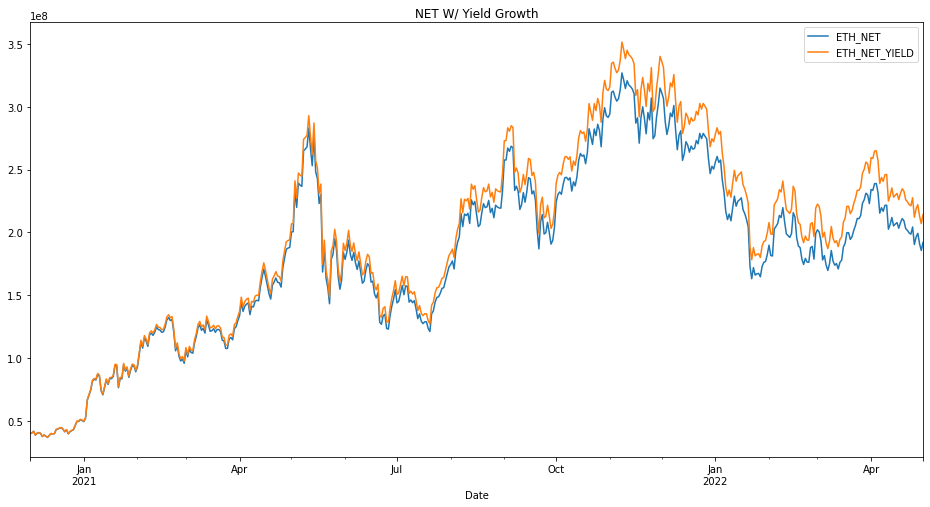

In [37]:
pl = eth_yield_df.plot(y=['ETH_NET','ETH_NET_YIELD'],figsize=(16,8),title='NET W/ Yield Growth')

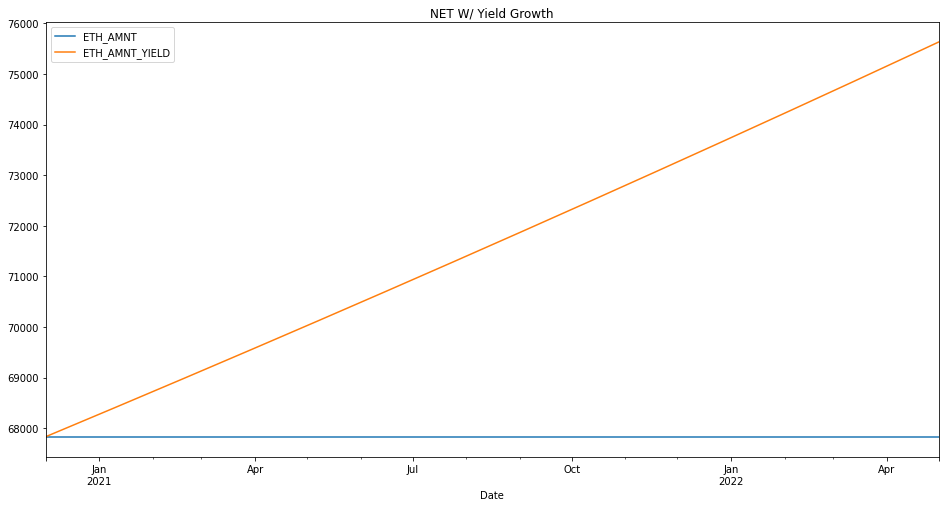

In [38]:
pl = eth_yield_df.plot(y=['ETH_AMNT','ETH_AMNT_YIELD'],figsize=(16,8),title='NET W/ Yield Growth')

In [40]:
sol_yield_df = pd.concat([sol_df['Close'],portfolio_df['SOL_AMNT'],portfolio_df['SOL_NET'],],axis=1)
sol_yield_df.columns = ['SOL_CLOSE_PRICE','SOL_AMNT','SOL_NET']
SOL_ANNUAL_YIELD = 5.75
SOL_ANNUAL_YIELD_PERCENTAGE = SOL_ANNUAL_YIELD / 100
#i_daily = (1 + i_annual) ^ (1/365) – 1
SOL_DAILY_YIELD_PERCENTAGE = (1 + SOL_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_SOL_YIELD_AMNT = SOL_INIT_AMNT * SOL_DAILY_YIELD_PERCENTAGE
print(SOL_DAILY_YIELD_PERCENTAGE)
print(INITIAL_DAILY_SOL_YIELD_AMNT)
sol_yield_df['Daily_Rate'] = SOL_DAILY_YIELD_PERCENTAGE
sol_yield_df['Day_Count'] = 1
sol_yield_df['Day_Count_Cum'] = sol_yield_df['Day_Count'].cumsum()
sol_yield_df['SOL_AMNT_YIELD'] = sol_yield_df['SOL_AMNT'] * (1 + SOL_DAILY_YIELD_PERCENTAGE) ** (sol_yield_df['Day_Count_Cum'])

#sol_yield_df['SOL_AMNT_YIELD'] = sol_yield_df['SOL_AMNT'] + (sol_yield_df['SOL_AMNT'] * sol_yield_df['Daily_Rate']).cumsum()
sol_yield_df['SOL_NET_YIELD'] = round(sol_yield_df['SOL_AMNT_YIELD'] * sol_yield_df['SOL_CLOSE_PRICE'],2)
sol_yield_df 

0.00015318332571911952
1936.5624452901725


,SOL_CLOSE_PRICE,SOL_AMNT,SOL_NET,Daily_Rate,Day_Count,Day_Count_Cum,SOL_AMNT_YIELD,SOL_NET_YIELD
Date,,,,,,,,
2020-12-01,1.977516,12642123,2.500000e+07,0.000153,1,1,1.264406e+07,2.500383e+07
2020-12-02,2.112355,12642123,2.670465e+07,0.000153,1,2,1.264600e+07,2.671283e+07
2020-12-03,2.098405,12642123,2.652829e+07,0.000153,1,3,1.264793e+07,2.654049e+07
2020-12-04,1.856668,12642123,2.347223e+07,0.000153,1,4,1.264987e+07,2.348662e+07
2020-12-05,1.977440,12642123,2.499904e+07,0.000153,1,5,1.265181e+07,2.501819e+07
...,...,...,...,...,...,...,...,...
2022-04-27,98.309653,12642123,1.242843e+09,0.000153,1,513,1.367557e+07,1.344441e+09
2022-04-28,98.129000,12642123,1.240559e+09,0.000153,1,514,1.367767e+07,1.342176e+09
2022-04-29,93.942711,12642123,1.187635e+09,0.000153,1,515,1.367976e+07,1.285114e+09


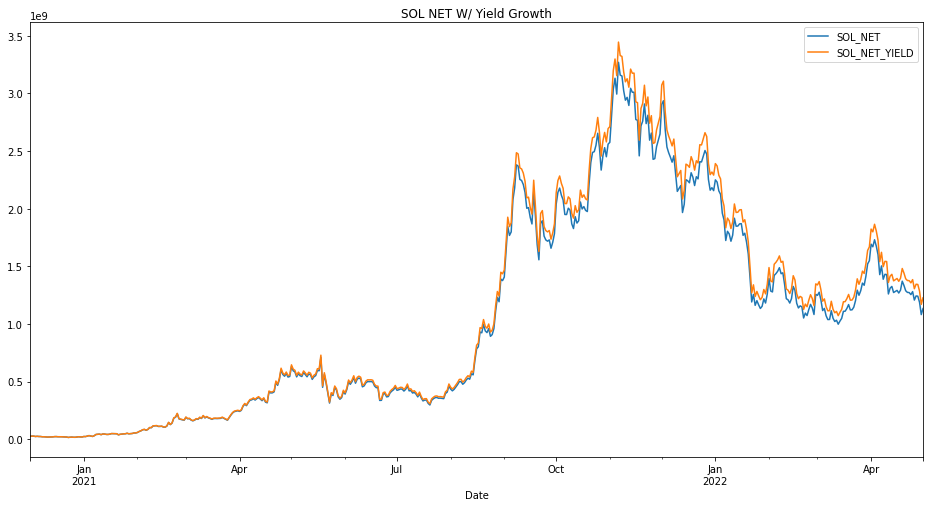

In [41]:
pl = sol_yield_df.plot(y=['SOL_NET','SOL_NET_YIELD'],figsize=(16,8),title='SOL NET W/ Yield Growth')

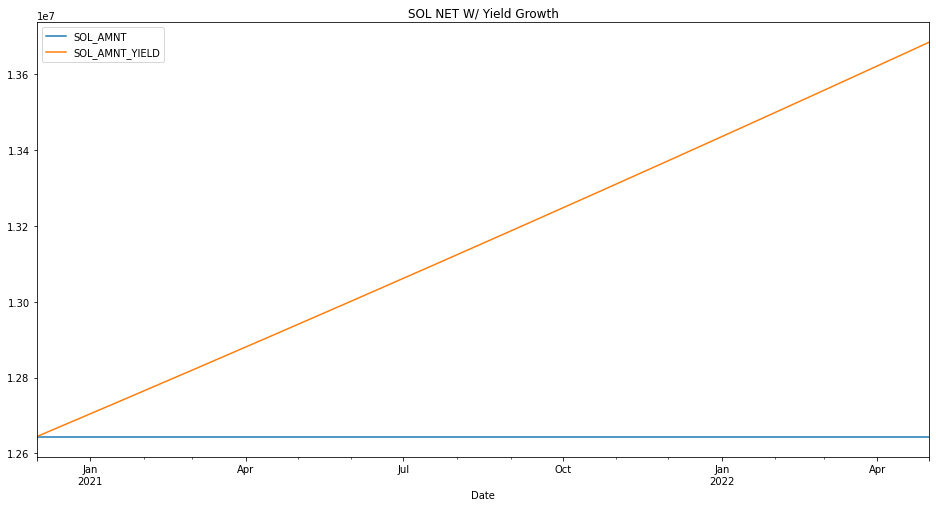

In [42]:
pl = sol_yield_df.plot(y=['SOL_AMNT','SOL_AMNT_YIELD'],figsize=(16,8),title='SOL NET W/ Yield Growth')

In [43]:
# Amount of SOL gained by staking....
amount = sol_yield_df['SOL_AMNT_YIELD'].iloc[-1] - sol_yield_df['SOL_AMNT_YIELD'].iloc[0]
value_current_price = amount * sol_yield_df['SOL_CLOSE_PRICE'].iloc[-1]
round(amount), "$"+"{:,.2f}".format(round(value_current_price,2))

(1039896, '$93,237,005.79')

In [44]:
near_yield_df = pd.concat([near_df['Close'],portfolio_df['NEAR_AMNT'],portfolio_df['NEAR_NET'],],axis=1)
near_yield_df.columns = ['NEAR_CLOSE_PRICE','NEAR_AMNT','NEAR_NET']
NEAR_ANNUAL_YIELD = 10
NEAR_ANNUAL_YIELD_PERCENTAGE = NEAR_ANNUAL_YIELD / 100
#i_daily = (1 + i_annual) ^ (1/365) – 1
NEAR_DAILY_YIELD_PERCENTAGE = (1 + NEAR_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_NEAR_YIELD_AMNT = NEAR_INIT_AMNT * NEAR_DAILY_YIELD_PERCENTAGE
print(NEAR_DAILY_YIELD_PERCENTAGE)
print(INITIAL_DAILY_NEAR_YIELD_AMNT)
near_yield_df['Daily_Rate'] = NEAR_DAILY_YIELD_PERCENTAGE

near_yield_df['Day_Count'] = 1
near_yield_df['Day_Count_Cum'] = near_yield_df['Day_Count'].cumsum()
near_yield_df['NEAR_AMNT_YIELD'] = near_yield_df['NEAR_AMNT'] * (1 + NEAR_DAILY_YIELD_PERCENTAGE) ** (near_yield_df['Day_Count_Cum'])
#near_yield_df['NEAR_AMNT_YIELD'] = near_yield_df['NEAR_AMNT'] + (near_yield_df['NEAR_AMNT'] * near_yield_df['Daily_Rate']).cumsum()
near_yield_df['NEAR_NET_YIELD'] = round(near_yield_df['NEAR_AMNT_YIELD'] * near_yield_df['NEAR_CLOSE_PRICE'],2)
near_yield_df

0.00026115787606784124
1214.0830086843555


,NEAR_CLOSE_PRICE,NEAR_AMNT,NEAR_NET,Daily_Rate,Day_Count,Day_Count_Cum,NEAR_AMNT_YIELD,NEAR_NET_YIELD
Date,,,,,,,,
2020-12-01,1.075536,4648847,5000000.28,0.000261,1,1,4.650061e+06,5001306.07
2020-12-02,1.176352,4648847,5468682.27,0.000261,1,2,4.651275e+06,5471539.02
2020-12-03,1.155287,4648847,5370750.32,0.000261,1,3,4.652490e+06,5374959.26
2020-12-04,1.106827,4648847,5145471.11,0.000261,1,4,4.653705e+06,5150848.34
2020-12-05,1.111261,4648847,5166080.90,0.000261,1,5,4.654921e+06,5172830.24
...,...,...,...,...,...,...,...,...
2022-04-27,12.821237,4648847,59603968.74,0.000261,1,513,5.315227e+06,68147785.33
2022-04-28,12.390900,4648847,57603398.29,0.000261,1,514,5.316615e+06,65877646.93
2022-04-29,11.238076,4648847,52244096.65,0.000261,1,515,5.318004e+06,59764130.02


In [48]:
# Amount of NEAR gained by staking....
amount = near_yield_df['NEAR_AMNT_YIELD'].iloc[-1] - near_yield_df['NEAR_AMNT_YIELD'].iloc[0]
value_current_price = amount * near_yield_df['NEAR_CLOSE_PRICE'].iloc[-1]
round(amount), "$"+"{:,.2f}".format(round(value_current_price,2))

(670721, '$7,976,209.43')

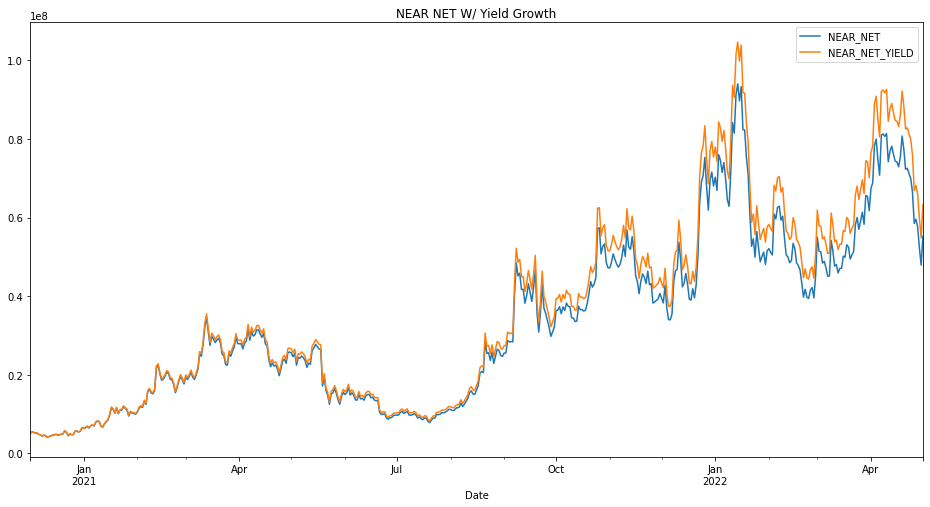

In [46]:
pl = near_yield_df.plot(y=['NEAR_NET','NEAR_NET_YIELD'],figsize=(16,8),title='NEAR NET W/ Yield Growth')

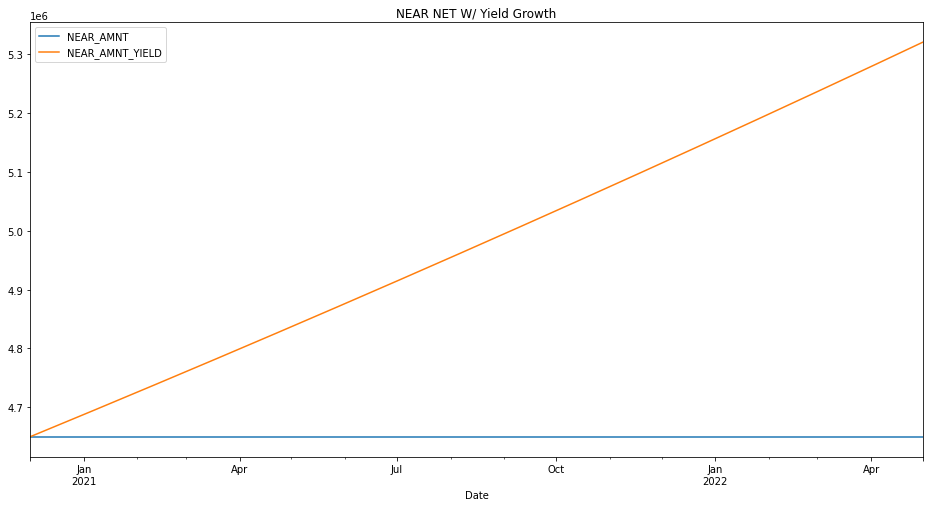

In [47]:
pl = near_yield_df.plot(y=['NEAR_AMNT','NEAR_AMNT_YIELD'],figsize=(16,8),title='NEAR NET W/ Yield Growth')

In [49]:
ftm_yield_df = pd.concat([ftm_df['Close'],portfolio_df['FTM_AMNT'],portfolio_df['FTM_NET'],],axis=1)
ftm_yield_df.columns = ['FTM_CLOSE_PRICE','FTM_AMNT','FTM_NET']
FTM_ANNUAL_YIELD = 14.19
FTM_ANNUAL_YIELD_PERCENTAGE = FTM_ANNUAL_YIELD / 100
#i_daily = (1 + i_annual) ^ (1/365) – 1
FTM_DAILY_YIELD_PERCENTAGE = (1 + FTM_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_FTM_YIELD_AMNT = FTM_INIT_AMNT * FTM_DAILY_YIELD_PERCENTAGE
print(FTM_DAILY_YIELD_PERCENTAGE)
print(INITIAL_DAILY_FTM_YIELD_AMNT)
ftm_yield_df['Daily_Rate'] = FTM_DAILY_YIELD_PERCENTAGE
ftm_yield_df['Day_Count'] = 1
ftm_yield_df['Day_Count_Cum'] = ftm_yield_df['Day_Count'].cumsum()
ftm_yield_df['FTM_AMNT_YIELD'] = ftm_yield_df['FTM_AMNT'] * (1 + FTM_DAILY_YIELD_PERCENTAGE) ** (ftm_yield_df['Day_Count_Cum'])
#ftm_yield_df['FTM_AMNT_YIELD'] = ftm_yield_df['FTM_AMNT'] + (ftm_yield_df['FTM_AMNT'] * ftm_yield_df['Daily_Rate']).cumsum()
ftm_yield_df['FTM_NET_YIELD'] = round(ftm_yield_df['FTM_AMNT_YIELD'] * ftm_yield_df['FTM_CLOSE_PRICE'],2)
ftm_yield_df

0.0003636100400432607
88516.26639957547


,FTM_CLOSE_PRICE,FTM_AMNT,FTM_NET,Daily_Rate,Day_Count,Day_Count_Cum,FTM_AMNT_YIELD,FTM_NET_YIELD
Date,,,,,,,,
2020-12-01,0.020539,243437355,5.000000e+06,0.000364,1,1,2.435259e+08,5.001818e+06
2020-12-02,0.022646,243437355,5.512987e+06,0.000364,1,2,2.436144e+08,5.516997e+06
2020-12-03,0.022888,243437355,5.571880e+06,0.000364,1,3,2.437030e+08,5.577961e+06
2020-12-04,0.021042,243437355,5.122469e+06,0.000364,1,4,2.437916e+08,5.129923e+06
2020-12-05,0.022497,243437355,5.476639e+06,0.000364,1,5,2.438803e+08,5.486603e+06
...,...,...,...,...,...,...,...,...
2022-04-27,0.986282,243437355,2.400979e+08,0.000364,1,513,2.933474e+08,2.893233e+08
2022-04-28,0.968966,243437355,2.358825e+08,0.000364,1,514,2.934541e+08,2.843470e+08
2022-04-29,0.832615,243437355,2.026895e+08,0.000364,1,515,2.935608e+08,2.444230e+08


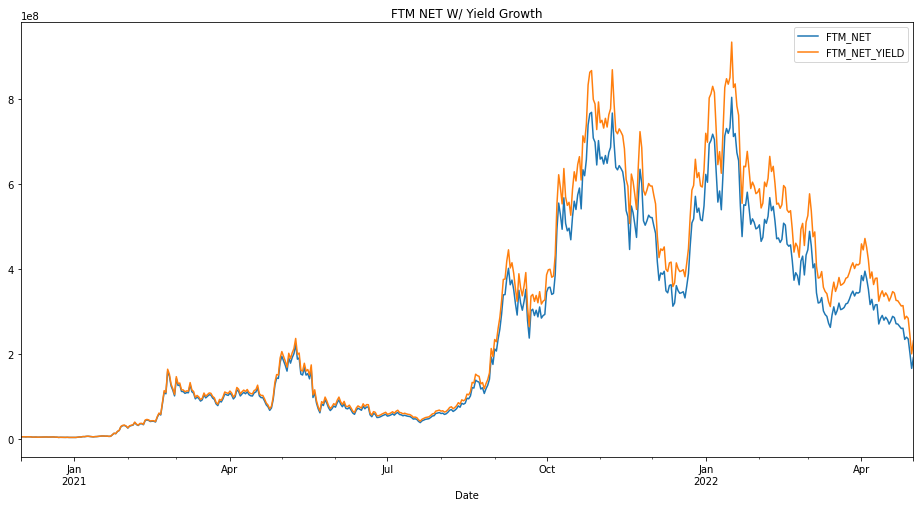

In [50]:
pl = ftm_yield_df.plot(y=['FTM_NET','FTM_NET_YIELD'],figsize=(16,8),title='FTM NET W/ Yield Growth')

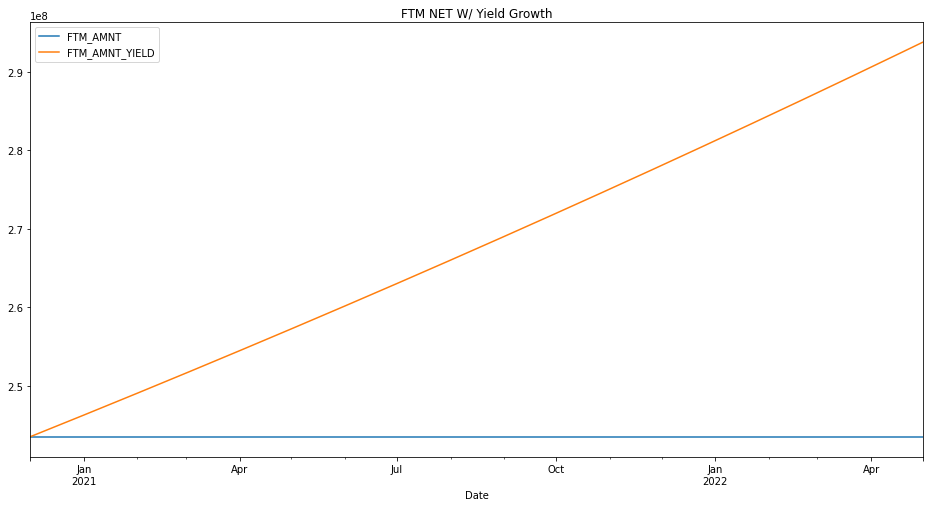

In [51]:
pl = ftm_yield_df.plot(y=['FTM_AMNT','FTM_AMNT_YIELD'],figsize=(16,8),title='FTM NET W/ Yield Growth')

In [54]:
# Amount of FTM gained by staking....
amount = ftm_yield_df['FTM_AMNT_YIELD'].iloc[-1] - ftm_yield_df['FTM_AMNT_YIELD'].iloc[0] 
value_current_price = amount * ftm_yield_df['FTM_CLOSE_PRICE'].iloc[-1]
round(amount), "$"+"{:,.2f}".format(round(value_current_price,2))

(50248451, '$39,611,959.49')

In [56]:
luna_yield_df = pd.concat([luna_df['Close'],portfolio_df['LUNA_AMNT'],portfolio_df['LUNA_NET'],],axis=1)
luna_yield_df.columns = ['LUNA_CLOSE_PRICE','LUNA_AMNT','LUNA_NET']
LUNA_ANNUAL_YIELD = 10.00
LUNA_ANNUAL_YIELD_PERCENTAGE = LUNA_ANNUAL_YIELD / 100
#i_daily = (1 + i_annual) ^ (1/365) – 1
LUNA_DAILY_YIELD_PERCENTAGE = (1 + LUNA_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_LUNA_YIELD_AMNT = LUNA_INIT_AMNT * LUNA_DAILY_YIELD_PERCENTAGE
print(LUNA_DAILY_YIELD_PERCENTAGE)
print(INITIAL_DAILY_LUNA_YIELD_AMNT)
luna_yield_df['Daily_Rate'] = LUNA_DAILY_YIELD_PERCENTAGE
luna_yield_df['Day_Count'] = 1
luna_yield_df['Day_Count_Cum'] = luna_yield_df['Day_Count'].cumsum()
luna_yield_df['LUNA_AMNT_YIELD'] = luna_yield_df['LUNA_AMNT'] * (1 + LUNA_DAILY_YIELD_PERCENTAGE) ** (luna_yield_df['Day_Count_Cum'])

#luna_yield_df['LUNA_AMNT_YIELD'] = luna_yield_df['LUNA_AMNT'] + (luna_yield_df['LUNA_AMNT'] * luna_yield_df['Daily_Rate']).cumsum()
luna_yield_df['LUNA_NET_YIELD'] = round(luna_yield_df['LUNA_AMNT_YIELD'] * luna_yield_df['LUNA_CLOSE_PRICE'],2)
luna_yield_df

0.00026115787606784124
8742.929249007348


,LUNA_CLOSE_PRICE,LUNA_AMNT,LUNA_NET,Daily_Rate,Day_Count,Day_Count_Cum,LUNA_AMNT_YIELD,LUNA_NET_YIELD
Date,,,,,,,,
2020-12-01,0.388320,33477563,1.300000e+07,0.000261,1,1,3.348631e+07,1.300340e+07
2020-12-02,0.406310,33477563,1.360227e+07,0.000261,1,2,3.349505e+07,1.360938e+07
2020-12-03,0.506414,33477563,1.695351e+07,0.000261,1,3,3.350380e+07,1.696679e+07
2020-12-04,0.451015,33477563,1.509888e+07,0.000261,1,4,3.351255e+07,1.511466e+07
2020-12-05,0.509040,33477563,1.704143e+07,0.000261,1,5,3.352130e+07,1.706370e+07
...,...,...,...,...,...,...,...,...
2022-04-27,89.065569,33477563,2.981698e+09,0.000261,1,513,3.827634e+07,3.409104e+09
2022-04-28,88.665600,33477563,2.968308e+09,0.000261,1,514,3.828634e+07,3.394681e+09
2022-04-29,84.902554,33477563,2.842331e+09,0.000261,1,515,3.829634e+07,3.251457e+09


In [57]:
# Amount of LUNA gained by staking....
amount = luna_yield_df['LUNA_AMNT_YIELD'].iloc[-1] - luna_yield_df['LUNA_AMNT_YIELD'].iloc[0] 
value_current_price = amount * luna_yield_df['LUNA_CLOSE_PRICE'].iloc[-1]
round(amount), "$"+"{:,.2f}".format(round(value_current_price,2))

(4830034, '$397,372,249.44')

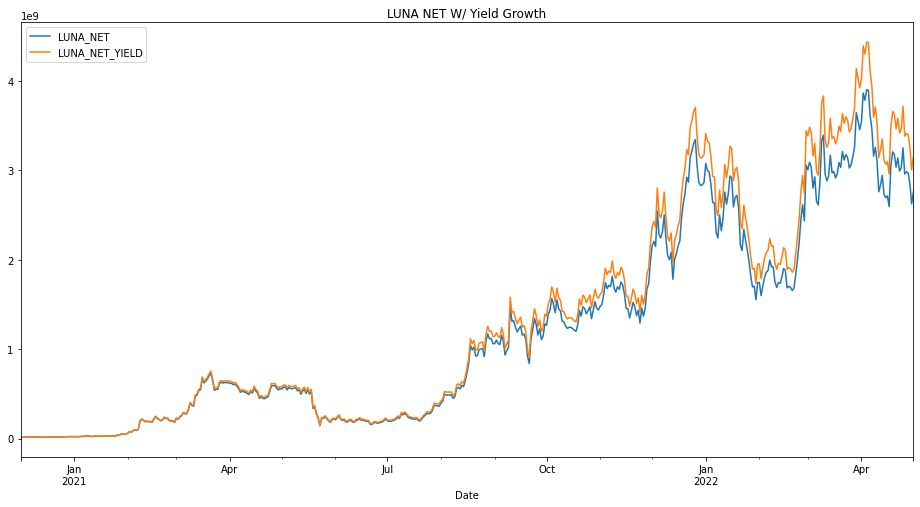

In [58]:
pl = luna_yield_df.plot(y=['LUNA_NET','LUNA_NET_YIELD'],figsize=(16,8),title='LUNA NET W/ Yield Growth')

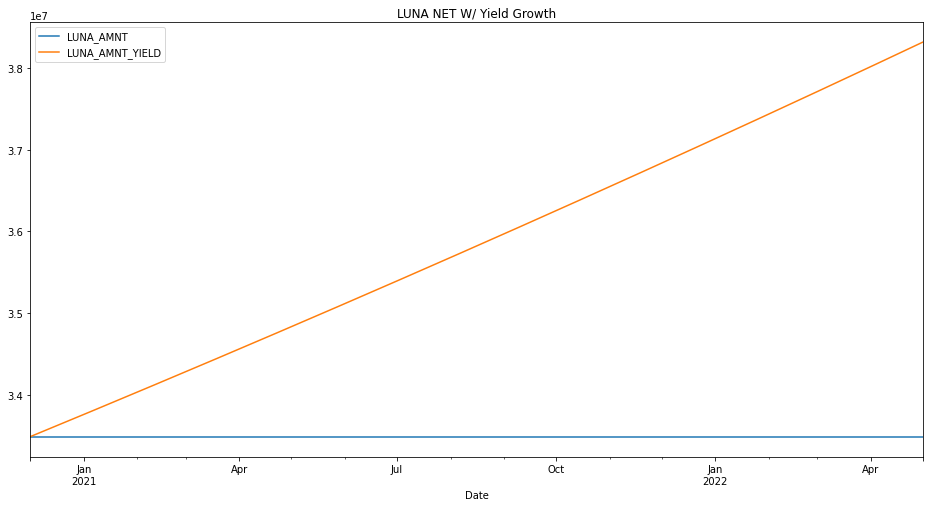

In [59]:
pl = luna_yield_df.plot(y=['LUNA_AMNT','LUNA_AMNT_YIELD'],figsize=(16,8),title='LUNA NET W/ Yield Growth')